In [15]:
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# input and output file locations. 
input_midi_path = "../../vickram_exploration/music_training_database/Pop/ABBA_-_Dancing_Queen.mid"
output_midi_path = "../../vickram_exploration/output_files"

In [17]:
# define the function to load the midi file and extract the notes
def load_midi(input_midi_path):
    """Load MIDI file using PrettyMIDI."""
    try:
        midi_data = pretty_midi.PrettyMIDI(input_midi_path)
        print(f"Loaded MIDI file: {input_midi_path}")
        return midi_data
    except Exception as e:
        print(f"Error loading MIDI file: {e}")
        return None

# Test the functions
midi_data = load_midi(input_midi_path)
print("MIDI Data Loaded:", midi_data is not None)

Loaded MIDI file: ../../vickram_exploration/music_training_database/Pop/ABBA_-_Dancing_Queen.mid
MIDI Data Loaded: True


In [18]:
# define the function to extract the notes from the midi file by instrument
def extract_notes(midi_data):
    """Extract notes, velocities, and timing from a MIDI file."""
    notes = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            # Notes: [start_time, end_time, pitch, velocity]
            notes.append([note.start, note.end, note.pitch, note.velocity])
    return np.array(notes)

notes = extract_notes(midi_data)
print("Notes Extracted:", notes.shape)

Notes Extracted: (8311, 4)


In [19]:
# Normalize Notes Data by scaling the velocity and timing
def normalize_notes(notes):
    """Normalize note velocities and timing."""
    max_velocity = 127  # Standard MIDI velocity range
    notes[:, 3] = notes[:, 3] / max_velocity  # Normalize velocity to [0, 1]
    return notes

# Test the function
normalized = normalize_notes(notes.copy())
print("Notes Normalized:", normalized[:5])

Notes Normalized: [[ 2.39044     2.40911531 42.          0.59055118]
 [ 2.98805     3.00672531 42.          0.59055118]
 [ 3.58566     3.60433531 42.          0.59055118]
 [ 4.18327     4.20194531 42.          0.59055118]
 [ 4.78088     4.79955531 42.          0.59055118]]


In [20]:
# define the function to convert the notes to sequenct of events using Note-On and Note-Off
def convert_to_events(notes):
    """Convert notes to a sequence of events (Note-On, Note-Off).""" 
    events = []
    for note in notes:
        # Note-On event (start time, 'Note-On', pitch, velocity)
        events.append([note[0], 'Note-On', int(note[2]), note[3]])
        # Note-Off event (end time, 'Note-Off', pitch, velocity=0.0)
        events.append([note[1], 'Note-Off', int(note[2]), 0.0])
    # Sort events by time
    events.sort(key=lambda x: (x[0], x[1]))
    return np.array(events)

# Test the function
events = convert_to_events(normalized)
print("Events Generated:", events.shape)

Events Generated: (16622, 4)


In [21]:

# define the function to visualize the notes using pitch vs. time and velocity vs. time
def visualize_notes(notes):
    """Visualize pitch vs. time and velocity vs. time.""" # notes: [start_time, end_time, pitch, velocity]
# By plotting the velocity vs. time, we can see the dynamics of the music
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.scatter(notes[:, 0], notes[:, 2], c=notes[:, 3], cmap='viridis', s=10)
    plt.colorbar(label='Velocity')
    plt.title('Pitch vs. Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Pitch')
# By plotting the pitch vs. time, we can see the melody of the music
    plt.subplot(2, 1, 2)
    plt.hist(notes[:, 3], bins=20, color='blue', alpha=0.7)
    plt.title('Velocity Distribution')
    plt.xlabel('Normalized Velocity')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()


Loaded MIDI file: ../../vickram_exploration/music_training_database/Pop/ABBA_-_Dancing_Queen.mid


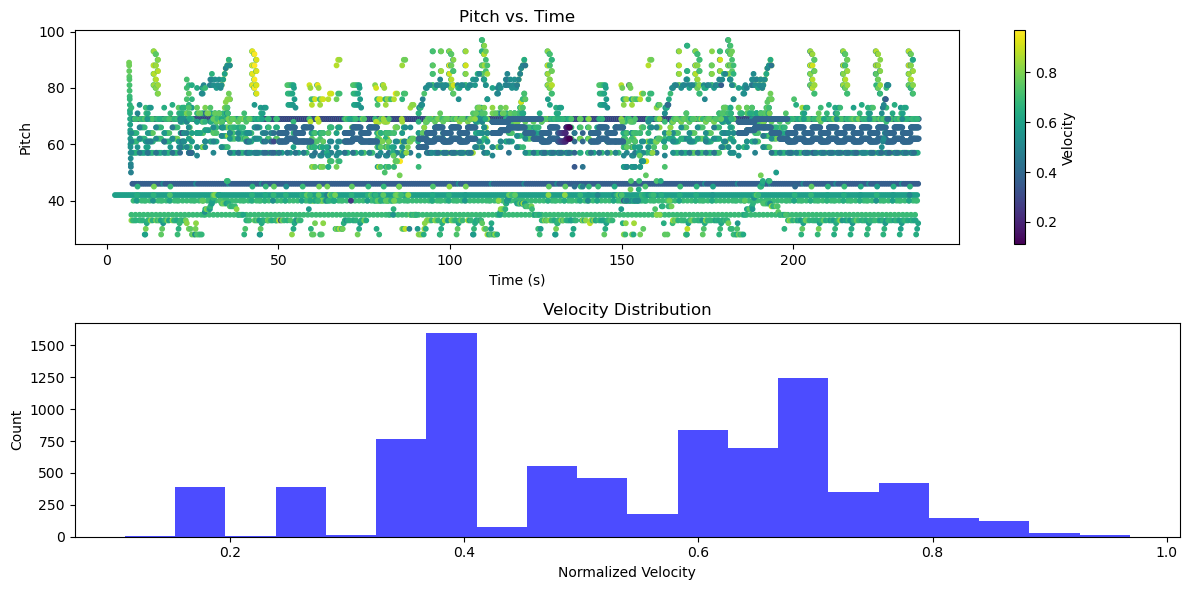

First few notes (normalized): [[ 2.39044     2.40911531 42.          0.59055118]
 [ 2.98805     3.00672531 42.          0.59055118]
 [ 3.58566     3.60433531 42.          0.59055118]
 [ 4.18327     4.20194531 42.          0.59055118]
 [ 4.78088     4.79955531 42.          0.59055118]]
First few events: [['2.39044' 'Note-On' '42' '0.5905511811023622']
 ['2.4091153125' 'Note-Off' '42' '0.0']
 ['2.98805' 'Note-On' '42' '0.5905511811023622']
 ['3.0067253124999995' 'Note-Off' '42' '0.0']
 ['3.58566' 'Note-On' '42' '0.5905511811023622']]


In [22]:
# Main Execution Flow
input_midi_path = "../../vickram_exploration/music_training_database/Pop/ABBA_-_Dancing_Queen.mid"

# Step 1: Load MIDI file
midi_data = load_midi(input_midi_path)
if midi_data:
    # Step 2: Extract and preprocess notes
    notes = extract_notes(midi_data)
    notes = normalize_notes(notes)

    # Step 3: Convert to events
    events = convert_to_events(notes)

    # Step 4: Visualize data
    visualize_notes(notes)

    # Inspect data
    print("First few notes (normalized):", notes[:5])
    print("First few events:", events[:5])


In [23]:
# Tokenization of MIDI Events to create a vocabulary
def tokenize_events(events):
    """Conver events into a tokenized format (unique integer IDs)."""
    token_vocab = {}
    tokenized = []
    for event in events:
        token = f"{event[1]}_{event[2]}" # Format: 'Note-On_60' or 'Note-Off_60'
        if token not in token_vocab:
            token_vocab[token] = len(token_vocab) # Assign unique ID
        tokenized.append(token_vocab[token])
    return np.array(tokenized), token_vocab

In [24]:
# Test the function 
tokenized_events, event_vocab = tokenize_events(events)
print("Tokenized Events:", tokenized_events.shape)
print("Vocabulary Size:", len(event_vocab))

Tokenized Events: (16622,)
Vocabulary Size: 116


In [25]:
# Sequnce Preparation 
# Split the tokenized events into sequences of fixed input-output pairs for taining. 
def prepare_sequences(tokenized_events, sequence_length=50):
    """Prepare input-output sequences from tokenized events for training."""
    inputs = []
    targets = []
    for i in range(len(tokenized_events) - sequence_length):
        inputs.append(tokenized_events[i:i+sequence_length])
        targets.append(tokenized_events[i+sequence_length])
    return np.array(inputs), np.array(targets)

# Test the function
sequence_length = 50 # Example sequence length
inputs, targets = prepare_sequences(tokenized_events, sequence_length)
print("Inputs Shape:", inputs.shape)
print("Target Shape:", targets.shape)

Inputs Shape: (16572, 50)
Target Shape: (16572,)


In [26]:
# Dataset and DataLoader
# Create a PyTorch dataset and dataloader for training the model
import torch
from torch.utils.data import Dataset, DataLoader
class MIDIDataset(Dataset):
    def __init__(self, inputs, targets):
        """PyTorch Dataset and DataLoader for MIDI data.
        Args:
            inputs (np.ndarray): Input sequences (shape: [num_sequences, sequence_length]).
            targets (np.ndarray): Target sequences(shape: [num_sequences, sequence_length]).
        """

        if len(inputs) != len(targets):
            raise ValueError("Inputs and Targets must have the same number of sequences.")
        self.inputs = torch.from_numpy(inputs).long()
        self.targets = torch.from_numpy(targets).long()

    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.targets[idx], dtype=torch.long)

# Create Dataset and DataLoader
dataset = MIDIDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Test the DataLoader 
for batch_inputs, batch_targets in dataloader:
    print("Batch Inputs Shape:", batch_inputs.shape)
    print("Batch Targets Shape:", batch_targets.shape)
    print("Sample Input Sequence:", batch_inputs[0])
    print("Sample Target Sequence:", batch_targets[0])
    break  # Test one batch

Batch Inputs Shape: torch.Size([64, 50])
Batch Targets Shape: torch.Size([64])
Sample Input Sequence: tensor([28, 64, 21, 33, 40, 65, 33, 65, 40, 45, 21, 57, 50, 64, 34, 28, 28, 33,
        58, 40, 64, 28, 21, 64, 28, 21, 34, 33, 65, 40, 21,  0, 49, 28, 64, 65,
        33,  1, 53, 40, 33, 56, 45, 40, 65, 28, 64, 21, 59, 50])
Sample Target Sequence: tensor(33)


/var/folders/g1/tng_t05j6qdf1rzj0_hgs2s00000gn/T/ipykernel_6448/4204181203.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.targets[idx], dtype=torch.long)


(1) Define the LSTM Model 
* Input Layer: Accepts tokenized sequences.
* Embedding Layer: Converts token indices into dense representations. 
* LSTM Layers: Captures temporal dependencies in sequences. 
* Dense Output Layer: Predices the next token in the sequence. 

(2) Specify Loss Function and Optimizer
* Loss: CrossEntropyLoss for token prediction. 
* Optimizer: Adam optimizer for efficient training. 

(3) Train the Model
* Implement a training loop.
* Track loss and save the model periodically.

(4) Evaluate the Model
* Measure accuracy on validation data.
* Visualize predictions. 

In [27]:
# LSTM Model Architecture
# Model Definition 
import torch.nn as nn
import torch.optim as optim 

class MIDIStyleTransferModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2):
        super(MIDIStyleTransferModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x
# Initialize the model
vocab_size = len(event_vocab)
model = MIDIStyleTransferModel(vocab_size)
print(model)

MIDIStyleTransferModel(
  (embedding): Embedding(116, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=116, bias=True)
)


In [28]:
# Loss Function and Optimizer 
# Define the loss function and optimizer for training the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
# Training Loop
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    """Train the model using the provided dataloader."""
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0 
        for batch_inputs, batch_targets in dataloader:
            print(F"Batch Inputs Shape: {batch_inputs.shape}") # Should be [64, seg_length]
            print(f"Batch Targets Shape: {batch_targets.shape}") # Should be [64, seq_length]
            # Move data to cpu if available
            batch_inputs, batch_targets = batch_inputs.to("cpu"), batch_targets.to("cpu")

            # Forward pass
            outputs = model(batch_inputs)
            print(f"Model Outputs Shape: {outputs.shape}") # Should be [64*seq_length, vocab_size]
            
            outputs = outputs.view(-1, outputs.size(-1)) # Flatten outputs for loss calculation
            batch_targets = batch_targets.view(-1) # Flatten targets for loss calculation
            
            # Compute the loss
            loss = criterion(outputs, batch_targets)

            # Backward pass optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Log training progress 
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

In [33]:
# Model Evaluation 
# Generate MIDI events using the trained model
def evaluate_model(model, dataloader):
    model.eval()
    total_correct = 0 
    total_tokens = 0 
    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            batch_inputs, batch_targets = batch_inputs.to("cpu"), batch_targets.to("cpu")
            outputs = model(batch_inputs)
            predictions = torch.argmax(outputs, dim=-1)
            total_correct += (predictions.view(-1) == batch_targets.view(-1)).sum().item()
            total_tokens += batch_targets.numel()
    accuracy = total_correct / total_tokens
    print(f"Validation Accuracy: {accuracy:.4f}")



In [35]:
# Training and Validation 
# Train the model using the MIDI dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

# Evaluate the model
evaluate_model(model, val_loader)

Batch Inputs Shape: torch.Size([64, 50])
Batch Targets Shape: torch.Size([64])
Model Outputs Shape: torch.Size([64, 50, 116])


/var/folders/g1/tng_t05j6qdf1rzj0_hgs2s00000gn/T/ipykernel_6448/4204181203.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.targets[idx], dtype=torch.long)


ValueError: Expected input batch_size (3200) to match target batch_size (64).